## Object Localization with TensorFlow

#### Extracting emoji dataset from Github

In [39]:
# import os
# import zipfile
# import requests

# url = "https://github.com/hfg-gmuend/openmoji/releases/latest/download/openmoji-72x72-color.zip"
# zip_path = "openmoji-72x72-color.zip"
# extract_dir = "emojis"

# if not os.path.exists(zip_path):
#     response = requests.get(url)
#     with open(zip_path, "wb") as f:
#         f.write(response.content)

# os.makedirs(extract_dir, exist_ok=True)
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# print(f"Extracted to: {extract_dir}")


#### Importing Libraries

In [40]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw
from tensorflow.keras.layers import Input,Dense,Flatten,Conv2D, MaxPool2D, BatchNormalization , Dropout

In [41]:
tf.__version__

'2.18.0'

#### Labeling Emojis and Visualization of Emojis

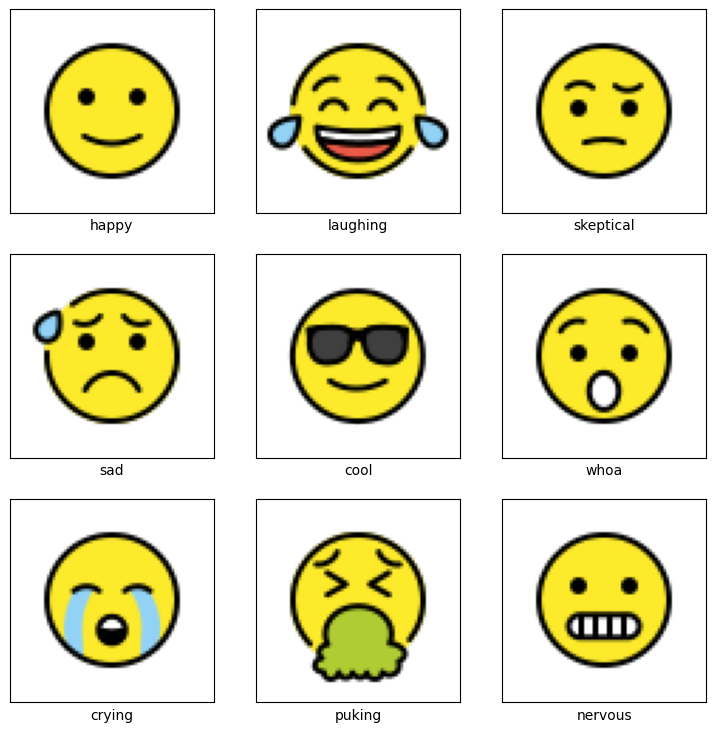

In [42]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

#### Creating random examples

now we will make a larger box and randomly place the emoji in it and the task of the model would be to locate the emoji

In [43]:
# adding the image to the dictionary
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [44]:
emojis

{0: {'name': 'happy',
  'file': '1F642.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 1: {'name': 'laughing',
  'file': '1F602.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 2: {'name': 'skeptical',
  'file': '1F928.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 3: {'name': 'sad',
  'file': '1F630.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 4: {'name': 'cool',
  'file': '1F60E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 5: {'name': 'whoa',
  'file': '1F62F.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 6: {'name': 'crying',
  'file': '1F62D.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 7: {'name': 'puking',
  'file': '1F92E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 8: {'name': 'nervous',
  'file': '1F62C.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>}}

In [45]:
#randomly placing the emoji in a box
def random_placement():
    class_id  = np.random.randint(0,9)
    image = np.ones((144,144,3))*255 #emoji was 72x72
    row = np.random.randint(0,72)
    column = np.random.randint(0,72)
    image[row:row+72,column:column+72] = np.array(emojis[class_id]['image'])
    return image.astype('uint8'),class_id, (row+10)/144,(column+10)/144 
#the offset of 10 is to utilize the empty space around the emoji

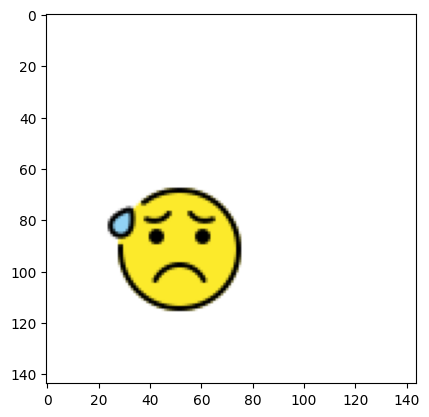

In [46]:
image,clas_id,row,column = random_placement()
plt.imshow(image)

#### Plotting Boundaries

In [47]:
def plot_boundaries(image,ground_truth_coords,predicted_coords=[],norm = False):
    if(norm): #checks if image values are normalised or not
        image =image*255
        image = image.astype('uint8')
    image =Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    
    row,column = ground_truth_coords
    row = row*144
    column = column*144
    draw.rectangle((column,row,column+52,row+52),outline='green',width=2)# 52 because we removed offset of 10 from both sides
    
    if len(predicted_coords)==2:
        row,column = predicted_coords
        row = row*144
        column = column*144
        draw.rectangle((column,row,column+52,row+52),outline='red',width=2)
    
    return image

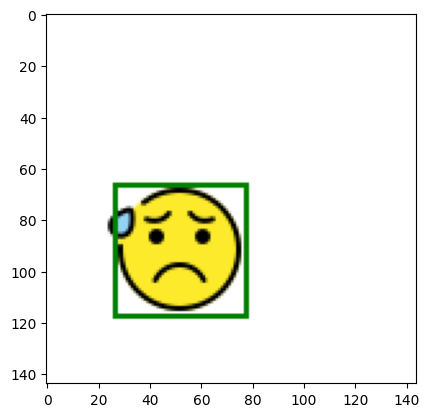

In [48]:
image = plot_boundaries(image,ground_truth_coords=[row,column])
plt.imshow(image)
plt.show()

#### Data Generation

In [49]:
def data_generation(batch_size=16):
    while True:
        x_batch = np.zeros((batch_size,144,144,3))
        y_batch = np.zeros((batch_size,9))
        bbox_batch = np.zeros((batch_size,2))
        
        for i in range(0,batch_size):
            image,class_id,row,column = random_placement()
            x_batch[i] = image/255
            y_batch[i,class_id] = 1.0
            bbox_batch[i] = np.array([row,column])  
        yield {'image':x_batch}, {'class_out':y_batch,'box_out':bbox_batch}         

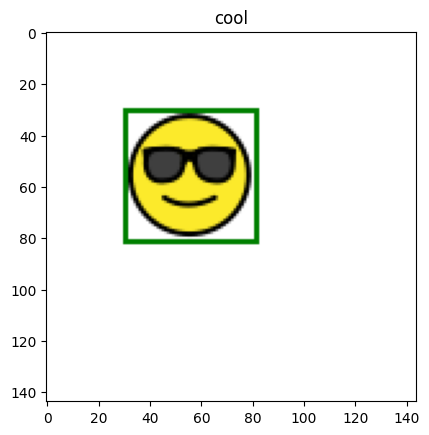

In [50]:
example,label = next(data_generation(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_boundaries(image, coords,norm=True)
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

#### Training a CNN Model

In [51]:
input_ = Input(shape=(144,144,3),name='image')
x= input_
for i in range(0,5):
    n_filters = 2**(4+i)
    x = Conv2D(n_filters,3,activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)
    
x = Flatten()(x)
x = Dense(256,activation='relu')(x)

class_out = Dense(9,activation='softmax',name ='class_out')(x)
box_out = Dense(2,name='box_out')(x)

model = tf.keras.models.Model(input_,[class_out,box_out])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 144, 144,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 142, 142,  │        448 │ image[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 142, 142,  │         64 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 71, 71,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 69, 69,    │      4,640 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 69, 69,    │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 34, 34,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 5, 5, 256) │    295,168 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 256) │      1,024 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 2, 2, 256) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1024)      │          0 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 659,819 (2.52 MB)

 Trainable params: 658,827 (2.51 MB)

 Non-trainable params: 992 (3.88 KB)

#### Custom Metric : IoU (Intersection over Union)

In [52]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self,**kwargs):
        super(IoU,self).__init__(**kwargs)
        
        self.iou = self.add_weight(name='iou',initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou',initializer='zeros')
        self.num_ex=self.add_weight(name='num_ex',initializer='zeros')
        
    def update_state(self,y_true,y_pred,sample_weight=None):
        def get_box(y):
            rows,columns = y_true[:,0],y_true[:,1]
            rows,columns = rows*44,columns*144
            y1,y2 = rows,rows+52
            x1,x2 = columns,columns+52
            return x1,y1,x2,y2
        def get_area(x1,y1,x2,y2):
            return tf.math.abs(x2-x1)*tf.math.abs(y2-y1)
        
        gt_x1,gt_y1,gt_x2,gt_y2 = get_box(y_true)
        p_x1,p_y1,p_x2,p_y2 = get_box(y_pred)
        
        i_x1 = tf.maximum(gt_x1,p_x1)
        i_y1 = tf.maximum(gt_y1,p_y1)
        i_x2 = tf.minimum(gt_x2,p_x2)
        i_y2 = tf.minimum(gt_y2,p_y2)
        
        i_area = get_area(i_x1,i_y1,i_x2,i_y2)
        u_area = get_area(gt_x1,gt_y1,gt_x2,gt_y2)+get_area(p_x1,p_y1,p_x2,p_y2)-i_area
        
        iou = tf.math.divide(i_area,u_area)
        self.num_ex.assign_add(1)
        self.total_iou.assign(tf.reduce_mean(iou))
        self.iou = tf.math.divide(self.total_iou,self.num_ex)
        
    def result(self):
        return self.iou
    
    def reset_state(self):
        self.iou = self.add_weight(name='iou',initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou',initializer='zeros')
        self.num_ex=self.add_weight(name='num_ex',initializer='zeros')        
        

#### Compliling the model

In [53]:
model.compile(
    loss = {
        'class_out' : 'categorical_crossentropy',
        'box_out' : 'mse'
    },
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out' : 'accuracy',
        'box_out' : IoU(name='iou')
    }
)

#### Custom Callback : Model testing

In [54]:
def test_model(model,test_datagen):
    example,label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']
    
    pred_y,pred_box = model.predict(x)
    
    pred_coords = pred_box[0]
    gt_coords = box[0]
    pred_class = np.argmax(pred_y[0])
    image = x[0]
    
    gt = emojis[np.argmax(y[0])]['name']
    pred_class_name = emojis[pred_class]['name']
    
    image = plot_boundaries(image,gt_coords,pred_coords,norm=True)
    plt.imshow(image)
    plt.xlabel(f'Predicted:{pred_class_name}',color = 'red')
    plt.ylabel(f'Ground truth : {gt}',color='green')
    plt.xticks([])
    plt.yticks([])
    

In [55]:
def test(model):
    test_datagen = data_generation(1)
    
    plt.figure(figsize=(16,4))
    
    for i in range(0,6):
        plt.subplot(1,6,i+1)
        test_model(model,test_datagen)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


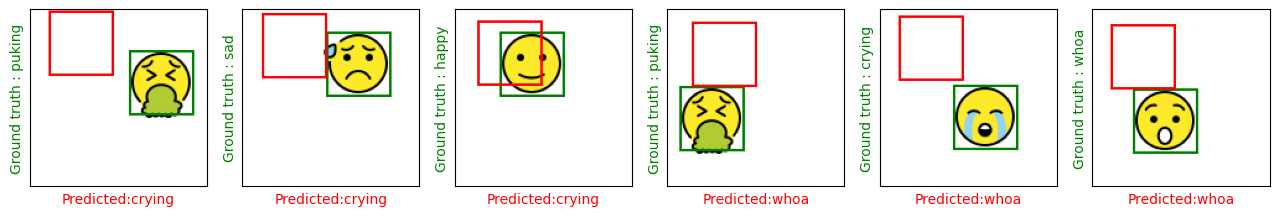

In [56]:
test(model)

In [59]:
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        try:
            test(self.model)
        except Exception as e:
            print(f"Error in ShowTestImages at epoch {epoch}: {e}")


#### Model Training

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step/step - box_out_iou: 3.9213e-04 - box_out_loss: 0.0033 - class_out_accuracy: 1.0000 - class_out_loss: 6.2710e-04 - loss: 0.003
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


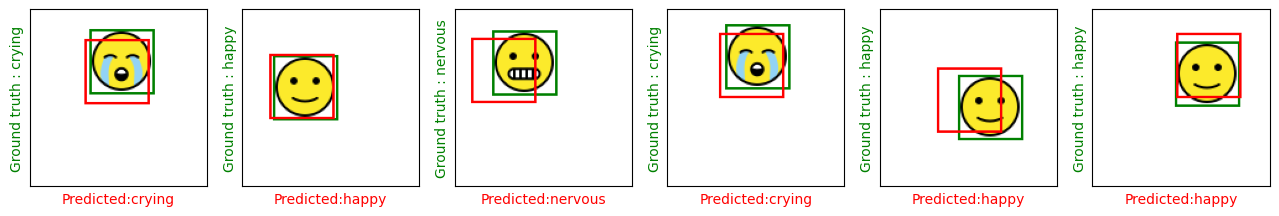

100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - box_out_iou: 3.8825e-04 - box_out_loss: 0.0033 - class_out_accuracy: 1.0000 - class_out_loss: 6.2831e-04 - loss: 0.0040 - learning_rate: 0.0010
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step/step - box_out_iou: 3.7733e-04 - box_out_loss: 0.0029 - class_out_accuracy: 1.0000 - class_out_loss: 5.6580e-04 - loss: 0.003
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


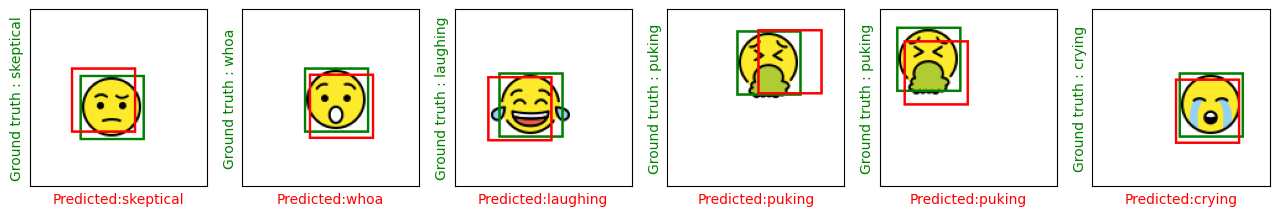

100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - box_out_iou: 3.7360e-04 - box_out_loss: 0.0029 - class_out_accuracy: 1.0000 - class_out_loss: 5.6520e-04 - loss: 0.0035 - learning_rate: 0.0010
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step/step - box_out_iou: 3.6361e-04 - box_out_loss: 0.0032 - class_out_accuracy: 1.0000 - class_out_loss: 6.8012e-04 - loss: 0.003
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


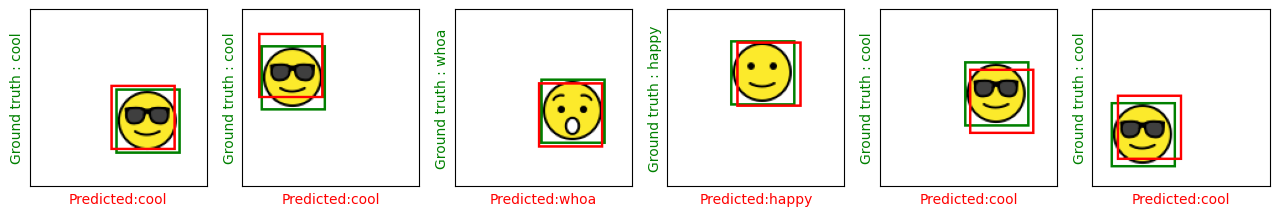

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - box_out_iou: 3.6001e-04 - box_out_loss: 0.0032 - class_out_accuracy: 1.0000 - class_out_loss: 6.7968e-04 - loss: 0.0039 - learning_rate: 0.0010
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step/step - box_out_iou: 3.5085e-04 - box_out_loss: 0.0050 - class_out_accuracy: 0.9972 - class_out_loss: 0.0126 - loss: 0.017
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


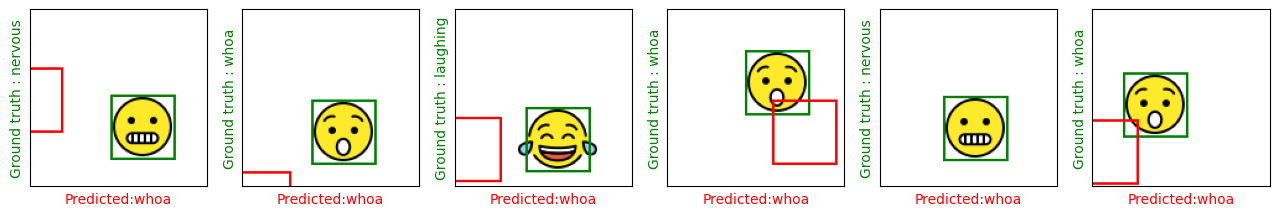

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - box_out_iou: 3.4738e-04 - box_out_loss: 0.0050 - class_out_accuracy: 0.9971 - class_out_loss: 0.0130 - loss: 0.0180 - learning_rate: 0.0010


In [61]:
def lr_schedule(epoch,lr):
    if(epoch+1)%5==0:
        lr*=0.2
    return max(lr,3e-7)

model.fit(
    data_generation(),
    epochs=10,
    steps_per_epoch = 100,
    callbacks = [
                    ShowTestImages(),
                    tf.keras.callbacks.LearningRateScheduler(lr_schedule),
                    tf.keras.callbacks.EarlyStopping(monitor = 'box_out_iou',patience=3,mode='max')
    ]
    
)